In [1]:
import torch
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the forward diffusion process
def forward_diffusion(x0, noise, t, T, batch_size):
    """
    Applies the forward diffusion process.
    
    Args:
    - x0: Original image tensor (batch_size, channels, height, width)
    - noise: Gaussian noise tensor with the same shape as x0
    - t: Current time step in the diffusion process
    - T: Total number of time steps
    
    Returns:
    - xt: Noised image tensor at time step t
    """
    alpha = 1 - (t / T)  # Simple linear schedule
    # y = x0 + (1 - alpha)
    alpha = alpha.view([batch_size,1,1,1]).to(device)
    # print(x0.shape," ",T)
    return alpha * x0 + (1 - alpha) * noise

# Simple U-Net-like model for reverse process (denoising)
class SimpleUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleUNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Sigmoid()  # Output in range [0, 1] for image generation
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Hyperparameters
T = 1000  # Number of time steps
batch_size = 1
learning_rate = 1e-4
epochs = 10

# Load MNIST dataset
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

data_path = "/kaggle/input/private-1/archive-3/Train/Raw"

class ImageDataset(Dataset):
    def __init__(self,path, transformer):
        self.path = path
        self.image_files = os.listdir(self.path)
        self.transform = transformer
    
    def __len__(self): 
        return len(os.listdir(self.path)) 
    
    def __getitem__(self, index):
        image_name = self.image_files[index]
        image_path = os.path.join(self.path, image_name)
        image = plt.imread(image_path)
        image = self.transform(image)
        image = image.to(device) 
        return image
        
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5) 
])

dataset = ImageDataset(data_path, transform)
X = DataLoader(dataset, batch_size=1, shuffle=True)


# Model, optimizer, loss
model = SimpleUNet(in_channels=3, out_channels=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss().to(device)

# Training loop
for epoch in range(epochs):
    model.train()
    
    for batch_idx, data in enumerate(X):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Apply forward diffusion (add noise)
        noise = torch.randn_like(data)
        t = torch.randint(0, T, (data.shape[0],))  # Random time steps
        xt = forward_diffusion(data, noise, t, T, batch_size).to(device)
        
        # Denoising step: predict original image from noisy image
        reconstructed = model(xt)
        loss = criterion(reconstructed, data)
        
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

Epoch 1/10, Loss: 0.24774329364299774
Epoch 2/10, Loss: 0.24717193841934204
Epoch 3/10, Loss: 0.4492083191871643
Epoch 4/10, Loss: 0.04336024448275566
Epoch 5/10, Loss: 0.38010287284851074
Epoch 6/10, Loss: 0.14311492443084717
Epoch 7/10, Loss: 0.32170891761779785
Epoch 8/10, Loss: 0.09059219807386398
Epoch 9/10, Loss: 0.39412885904312134
Epoch 10/10, Loss: 0.15869663655757904


In [4]:
import numpy as np

def test_model(
    model,
    input_image_path = "/kaggle/input/private-1/archive-3/Train/Raw/123_img_.png",
    reference_path = "/kaggle/input/private-1/archive-3/Train/Reference/123_img_.png"
):
    
    img = plt.imread(input_image_path)
    input_img = transform(img)
    input_img = input_img.unsqueeze(0).to(device)  # Adding batch dimension
    
    gen_img = model(input_img)
    gen_img = gen_img.squeeze(0).detach().cpu().numpy()  # Removing batch dimension
    
    # Loading the reference image
    ref_img = plt.imread(reference_path)
    ref_img = transform(ref_img).detach().cpu().numpy()
    
    # ref_img is in the range [-1, 1], so we need to scale them back to [0, 1]
    ref_img = (ref_img + 1) / 2  # Convert to range [0, 1]
    input_img = input_img.squeeze(0).detach().cpu().numpy()
    input_img = (input_img + 1) / 2
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.transpose(input_img, (1, 2, 0)))  # (C, H, W) -> (H, W, C)
    plt.title('Input Image')
    
    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(gen_img, (1, 2, 0)))  # (C, H, W) -> (H, W, C)
    plt.title('Generated Image')
    
    plt.subplot(1, 3, 3)
    plt.imshow(np.transpose(ref_img, (1, 2, 0)))
    plt.title('Reference Image')

    plt.show()

from scikitlearn.metrics import structural_similarity as ssim

def ssim_on_test(model):

    test_path = "/kaggle/input/private-1/archive-3/Test/"
    
    model.eval()

    ssim_scores = []

    class ImageDataset(Dataset):
        def __init__(self,path, transformer):
            self.path = path
            self.image_files = os.listdir(self.path)
            self.transform = transformer
        
        def __len__(self): 
            return len(os.listdir(self.path)) 
        
        def __getitem__(self, index):
            image_name = self.image_files[index]
            image_path = os.path.join(self.path, image_name)
            try:
                input_image = plt.imread(image_path)
                target_image = plt.imread(image_path.replace("Raw", "Reference"))
            except Exception as e:
                return torch.zeros(1,1)
                
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)
            return input_image, target_image
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5),
    ])
    
    dataset = ImageDataset(test_path, transform)
    X_test = DataLoader(dataset, batch_size=1, shuffle=False)


    for data in X_test:
        if len(data) <= 1:
            continue

        raw_image, ref_image = data
        
        raw_image = raw_image.unsqueeze(0).to(device)
        
        ref_img = transform(ref_img).detach().cpu().numpy()
        ref_img = (ref_img + 1) / 2
        
        gen_image = model(raw_image)
        gen_img = gen_img.squeeze(0).detach().cpu().numpy()
        
        ssim_score, _ = ssim(gen_image, ref_image, full=True)
        ssim_scores.append(ssim_score)
    
    overall_ssim = np.mean(ssim_scores)
    print(f'Overall SSIM score: {overall_ssim}')


### ****Benchmark from the boilerplate code****

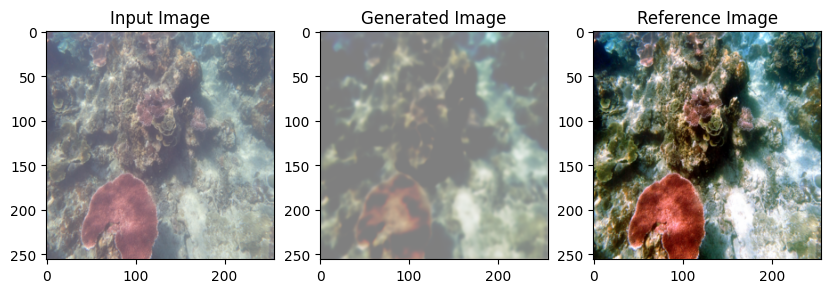

In [5]:
test_model(model)
ssim_on_test(model)

## Building up from the boilerplate code

### Noise function
Learnt about noise schedulers, mainly cosine schedulers, they are used enchancingly add more noise as the iterations go on by providing a more gradual and adaptive noise addition. They are a step ahead of the linear noise fucntion used before
Formula,
$\alpha_t = \cos\left(\frac{t}{T} \cdot \frac{\pi}{2}\right)$

Learnt this from this computerphile video, https://youtu.be/1CIpzeNxIhU?si=Gwfnoy-qbbzg9pva

### Improving the model architecture
I used residual blocks in the UNet architecture to prevent vanishing gradients during training. Residual blocks allow the network to learn identity mappings by using skip connections, which help the model retain important features across layers. This enables deeper networks, enhances feature propagation, and improves convergence.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cosine noise schedule
def cosine_schedule(t, T): 
    return 0.5 * (1 + torch.cos(math.pi * t / T))

def forward_diffusion(x0, noise, t, T, batch_size):
    alpha = cosine_schedule(t, T)  # Use the cosine schedule here
    alpha = alpha.view(batch_size, 1, 1 ,1).to(device)
    return alpha * x0 + (1 - alpha) * noise

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + identity)

# Enhanced U-Net with deeper layers and residual blocks
class EnhancedUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnhancedUNet, self).__init__()
        
        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            ResidualBlock(128),
            nn.MaxPool2d(2)
        )
        
        self.encoder2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            ResidualBlock(512),
            nn.MaxPool2d(2)
        )
        
        # Decoder
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            ResidualBlock(128)
        )
        
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.ReLU()
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        
        # Decoder with skip connections
        dec1 = self.decoder1(enc2) + enc1
        dec2 = self.decoder2(dec1)
        
        return dec2

# Hyperparameters
T = 2000  # Number of time steps
batch_size = 1
learning_rate = 1e-4
epochs = 10

# Dataset preparation (placeholder for your underwater images)
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
data_path = "/kaggle/input/private-1/archive-3/Train/Raw"

class ImageDataset(Dataset):
    def __init__(self,path, transformer):
        self.path = path
        self.image_files = os.listdir(self.path)
        self.transform = transformer
    
    def __len__(self): 
        return len(os.listdir(self.path)) 
    
    def __getitem__(self, index):
        image_name = self.image_files[index]
        image_path = os.path.join(self.path, image_name)
        try:
            input_image = plt.imread(image_path)
            target_image = plt.imread(image_path.replace("Raw", "Reference"))
        except Exception as e:
            return torch.zeros(1,1)
            
        input_image = self.transform(input_image)
        target_image = self.transform(target_image)
        return input_image, target_image

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5),
])

dataset = ImageDataset(data_path, transform)
X = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, optimizer, loss
model = EnhancedUNet(in_channels=3, out_channels=3).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
criterion = nn.MSELoss().to(device)

# Training loop with raw and enhanced images
for epoch in range(epochs):
    model.train()
    
    for data in X:
        if len(data) <= 1:
            continue
        raw_images, enhanced_images = data
        # Move images to the correct device (CPU/GPU)
        raw_images = raw_images.to(device)
        enhanced_images = enhanced_images.to(device)
        
        optimizer.zero_grad()
        
        # Apply forward diffusion to raw images (add noise)
        noise = torch.randn_like(raw_images)  # Gaussian noise
        t = torch.randint(0, T, (raw_images.shape[0],))  # Random time steps
        xt = forward_diffusion(raw_images, noise, t, T, batch_size)  # Noised image
        
        # Pass noisy image through the model to generate an enhanced version
        generated_images = model(xt)
        
        # Calculate loss between generated images and the true enhanced images
        loss = criterion(generated_images, enhanced_images)
        
        # Backpropagate and optimize
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

Epoch 1/10, Loss: 0.1574569046497345
Epoch 2/10, Loss: 0.27786195278167725
Epoch 3/10, Loss: 0.21773406863212585
Epoch 4/10, Loss: 0.20627117156982422
Epoch 5/10, Loss: 0.15836206078529358
Epoch 6/10, Loss: 0.16719400882720947
Epoch 7/10, Loss: 0.2610826790332794
Epoch 8/10, Loss: 0.1615438610315323
Epoch 9/10, Loss: 0.1266697496175766
Epoch 10/10, Loss: 0.2980126142501831


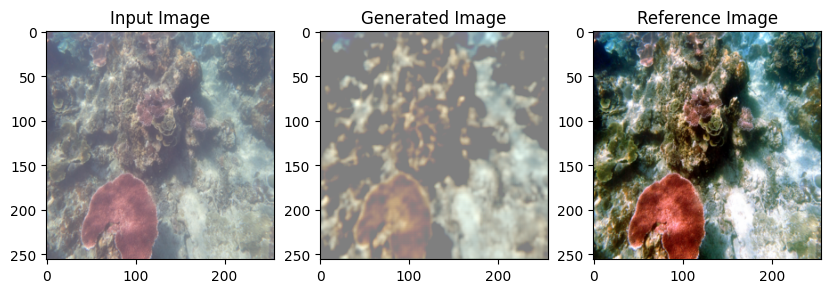

In [7]:
test_model(model)
ssim_on_test(model)

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cosine noise schedule
def cosine_schedule(t, T): 
    return 0.5 * (1 + torch.cos(math.pi * t / T))

def forward_diffusion(x0, noise, t, T, batch_size):
    alpha = cosine_schedule(t, T)  # Use the cosine schedule here
    alpha = alpha.view(batch_size, 1, 1 ,1).to(device)
    return alpha * x0 + (1 - alpha) * noise

# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + identity)

# Enhanced U-Net with deeper layers and residual blocks
class EnhancedUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnhancedUNet, self).__init__()
        
        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            ResidualBlock(128),
            nn.MaxPool2d(2)
        )
        
        self.encoder2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            ResidualBlock(512),
            nn.MaxPool2d(2)
        )
        
        # Decoder
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            ResidualBlock(128)
        )
        
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        
        # Decoder with skip connections
        dec1 = self.decoder1(enc2) + enc1
        dec2 = self.decoder2(dec1)
        
        return dec2

# Hyperparameters
T = 2000  # Number of time steps
batch_size = 1
learning_rate = 1e-4
epochs = 10

# Dataset preparation (placeholder for your underwater images)
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transform, download=True)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
data_path = "/kaggle/input/private-1/archive-3/Train/Raw"

class ImageDataset(Dataset):
    def __init__(self,path, transformer):
        self.path = path
        self.image_files = os.listdir(self.path)
        self.transform = transformer
    
    def __len__(self): 
        return len(os.listdir(self.path)) 
    
    def __getitem__(self, index):
        image_name = self.image_files[index]
        image_path = os.path.join(self.path, image_name)
        try:
            input_image = plt.imread(image_path)
            target_image = plt.imread(image_path.replace("Raw", "Reference"))
        except Exception as e:
            return torch.zeros(1,1)
            
        input_image = self.transform(input_image)
        target_image = self.transform(target_image)
        return input_image, target_image

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5),
])

dataset = ImageDataset(data_path, transform)
X = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, optimizer, loss
model = EnhancedUNet(in_channels=3, out_channels=3).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
criterion = nn.MSELoss().to(device)

# Training loop with raw and enhanced images
for epoch in range(epochs):
    model.train()
    
    for batch_idx, data in enumerate(X):
        if len(data) <= 1:
            continue
        raw_images, enhanced_images = data
        # Move images to the correct device (CPU/GPU)
        raw_images = raw_images.to(device)
        enhanced_images = enhanced_images.to(device)
        
        optimizer.zero_grad()
        
        # Apply forward diffusion to raw images (add noise)
        noise = torch.randn_like(raw_images)  # Gaussian noise
        t = torch.randint(0, T, (raw_images.shape[0],))  # Random time steps
        xt = forward_diffusion(raw_images, noise, t, T, batch_size)  # Noised image
        
        # Pass noisy image through the model to generate an enhanced version
        generated_images = model(xt)
        
        # Calculate loss between generated images and the true enhanced images
        loss = criterion(generated_images, enhanced_images)
        
        # Backpropagate and optimize
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

Epoch 1/10, Loss: 0.10373574495315552
Epoch 2/10, Loss: 0.08229508250951767
Epoch 3/10, Loss: 0.059175752103328705
Epoch 4/10, Loss: 0.12459276616573334
Epoch 5/10, Loss: 0.1626596450805664
Epoch 6/10, Loss: 0.06224647909402847
Epoch 7/10, Loss: 0.20739810168743134
Epoch 8/10, Loss: 0.04474407061934471
Epoch 9/10, Loss: 0.17403118312358856
Epoch 10/10, Loss: 0.02272176370024681


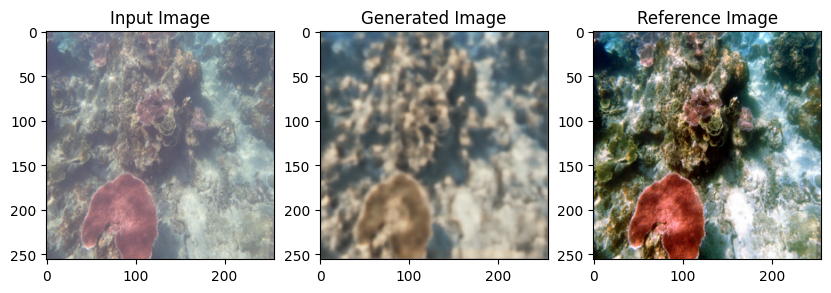

In [46]:
test_model(model)
ssim_on_test(model)